# Reactive Probabilistic Programming

## Bayesian Inference

**Exercice:** Infer the bias of a coin

- Each coin flip follows a Bernoulli distribution: $p(o | \theta) \sim \textrm{Bernoulli}(\theta)$ ()
- We assume a uniform prior $p(\theta) \sim \textrm{Uniform(0, 1)}$

**Question:** What is the bias of the coin $\theta$ given a series of observations $x_1, \dots, x_n$?

*Reminder*:
$$
p(A|B) = \frac{p(B|A) p(A)}{p(B)} \qquad \textrm{(Bayes rule)}
$$

**Solution**

$$
\begin{align}
p(\theta | x) &= \frac{p(x_1, \dots, x_n|\theta)p(\theta)}{p(x)}\\
& = \frac{p(x_1, \dots, x_n|\theta)p(\theta)}{\int_{\theta} p(x_1, \dots, x_n | \theta)}\\\\
& \propto p(x_1, \dots, x_n|\theta)p(\theta)\\\\
& \propto \theta^{\sum_{i = 1}^n x_1} (1-\theta)^{\sum_{i = 1}^n (1-x_i)}\\\\
&\sim \textrm{Beta}(1+\sum_{i = 1}^n x_i, 1 + \sum_{i = 1}^n (1-x_i))
\end{align}
$$

## Probabilistic Programming

Let's program our first probabilistic language

In [1]:
import numpy as np
from utils import plot_posterior, plot_pdf, animate_model
from torch.distributions import Bernoulli, Beta, Uniform

The two main constructs are:
- `sample(d)`: draw sample from a distribution `d`
- `observe(d, x)`: condition using the likelihood of observation `x` w.r.t. distribution `d`  

In [2]:
def sample(d):
    return d.sample().item()

def observe(d, x):
    return d.log_prob(x).item()

In [3]:
def coin(flip):
    theta = sample(Uniform(0, 1))
    score = observe(Bernoulli(theta), flip)
    return np.array([theta, score])

In [4]:
x = sample(Bernoulli(0.5))
coin(x)

array([ 0.69581544, -1.1901207 ])

### Importance sampling

To approximate the posterior distribution we need to accumulate the results and normalize the resulting distribution

In [5]:
def infer(model, data, n):
    results = np.array([model(data) for _ in range(n)])
    results[:,1] = np.exp(results[:,1])
    results[:,1] /= np.sum(results[:,1])
    return results

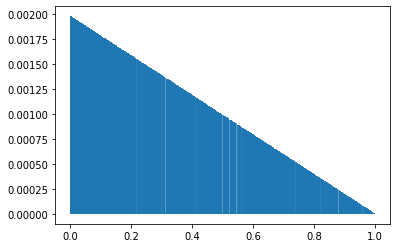

In [6]:
results = infer(coin, 0, 1000)
plot_posterior(results)

More interesting: let's condition on a series of inputs data

In [7]:
def coin(flips):
    theta = sample(Uniform(0, 1))
    score = 0
    for flip in flips:
        score += observe(Bernoulli(theta), flip)
    return np.array([theta, score])

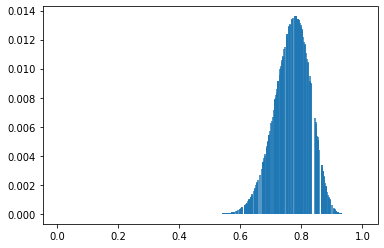

In [8]:
data = np.array([sample(Bernoulli(0.8)) for _ in range(50)])
results = infer(coin, data, 500)
plot_posterior(results)

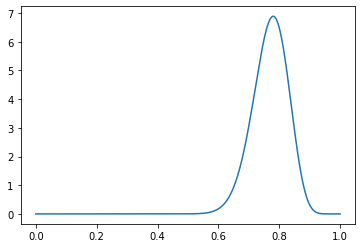

In [9]:
tails = np.sum(data) 
heads = np.sum(1 - data)
plot_pdf(Beta(tails+1, heads+1))

One more thing: we can hide the probabilistic state for the user

In [10]:
class Prob:
    def __init__(self, idx: int, scores):
        self.idx = idx
        self.scores = scores

def sample(prob, d):
    return d.sample().item()

def observe(prob, d, x):
    prob.scores[prob.idx] += d.log_prob(x)
    
def infer(model, data, n):
    scores = np.zeros(n) 
    values = np.array([model(Prob(i, scores), data) for i in range(n)])
    probs = np.exp(scores)
    probs /= np.sum(probs)
    return np.stack([values, probs], axis=1)

In [11]:
def coin(prob, flips):
    theta = sample(prob, Uniform(0, 1))
    for flip in flips:
        observe(prob, Bernoulli(theta), flip)
    return theta

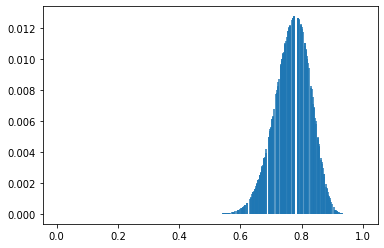

In [12]:
results = infer(coin, data, 500)
plot_posterior(results)

## Reactive Probabilistic Programming

*Reminder*: Zelus generate three methods for each nodes `n`
- `n.reset()` reinitialized the state
- `n.step(*inputs)` execute one step of the transition function using the `inputs`
- `n.copy(m)` copy the state of `n` in `m`

In [13]:
import pyzls

In [14]:
%%zelus -clear

let node nat(i) = o where
  rec o = 0 fby o + i

In [15]:
n = nat()
n.reset()
[n.step(1) for _ in range(10)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Let's move to probabilistic programming.
First probabilistic operators need to be lifted to zelus nodez. 
We use the `prob` trick to hide the state.

In [16]:
%%zelus_lib -clear -name infer_importance

type 'a dist

val sample : 'a dist ~D~> 'a
val observe : 'a dist * 'a ~D~> unit

val infer : int -S-> ('a ~D~> 'b) -S-> 'a -D-> 'b dist

In [17]:
%%save -clear -file infer_importance.py

from pyzls import CNode
import numpy as np


class Prob:
    def __init__(self, idx: int, scores):
        self.idx = idx
        self.scores = scores


class sample(CNode):
    def __init__(self):
        pass

    def reset(self):
        pass

    def copy(self, dest):
        pass

    def step(self, prob: Prob, d):
        return d.sample()


class observe(CNode):
    def __init__(self):
        pass

    def reset(self):
        pass

    def copy(self, dest):
        pass

    def step(self, prob: Prob, d, x):
        prob.scores[prob.idx] += d.log_prob(x)
        return ()

We do the same for `infer`.

In [18]:
%%save -file infer_importance.py

def infer(n: int):
    def infer(f: CNode):
        class infer(CNode):
            def __init__(self):
                self.scores = np.zeros(n)
                self.particles = [f() for _ in range(n)]

            def reset(self):
                self.scores.fill(0)
                for p in self.particles:
                    p.reset()

            def copy(self, dest):
                pass

            def step(self, *args):
                values = np.array(
                    [
                        p.step(Prob(i, self.scores), *args)
                        for i, p in enumerate(self.particles)
                    ]
                )
                probs = np.exp(self.scores) 
                probs /= np.sum(probs)
                return np.stack([values, probs], axis=1)

        return infer

    return infer

Let's try our first reactive probabilistic model: a kalman filter to track a position.

In [19]:
@pyzls.lib("dist")
def gaussian(*args: "'a") -> "'b":
    from torch.distributions import Normal
    return Normal(*args)

In [20]:
%%zelus -clear

open Dist
open Infer_importance

let proba kalman(x) = o where
     rec o = sample(gaussian(0. fby o, 2.))
     and _ = observe(gaussian(o, 4.), x)
     
let node tracker i = dist where
  rec dist = infer(100)(kalman)(i)

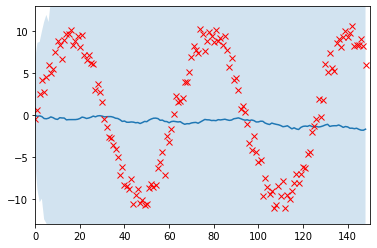

In [21]:
n = 150
noisy_sin = 10*np.sin(0.1*np.arange(n)) + np.random.randn(n)
animate_model(tracker(), noisy_sin)

Oupss

What happens here is that we always keep the same set of particles. The score keeps decreasing with each new observations. Eventually, all scores are so low that we get no informations.


### Particle Filtering

Same as before but:
- At each step we resample the particles
- We duplicate particles with high score and discard particles with low scores

In [22]:
%%zelus_lib -c -name infer_pf

type 'a dist
val sample : 'a dist ~D~> 'a
val observe : 'a dist * 'a ~D~> unit

val infer : int -S-> ('a ~D~> 'b) -S-> 'a -D-> 'b dist

In [23]:
%%save -clear -file infer_pf.py

from pyzls import CNode
import numpy as np


class Prob:
    def __init__(self, idx: int, scores):
        self.idx = idx
        self.scores = scores


class sample(CNode):
    def __init__(self):
        pass

    def reset(self):
        pass

    def copy(self, dest):
        pass

    def step(self, prob: Prob, d):
        return d.sample()


class observe(CNode):
    def __init__(self):
        pass

    def reset(self):
        pass

    def copy(self, dest):
        pass

    def step(self, prob: Prob, d, x):
        prob.scores[prob.idx] += d.log_prob(x)
        return ()


def infer(n: int):
    def infer(f: CNode):
        class infer(CNode):
            def __init__(self):
                self.scores = np.zeros(n)
                self.particles = [f() for _ in range(n)]

            def reset(self):
                self.scores.fill(0)
                for p in self.particles:
                    p.reset()

            def copy(self, dest):
                pass

            def step(self, *args):
                values = np.array(
                    [
                        p.step(Prob(i, self.scores), *args)
                        for i, p in enumerate(self.particles)
                    ]
                )
                probs = np.exp(self.scores)
                probs /= np.sum(probs)
                ids = np.random.choice(n, size=n, p=probs)
                particles = [f() for _ in range(n)]
                for i, idx in enumerate(ids):
                    self.particles[idx].copy(particles[i])
                self.particles = particles
                self.scores.fill(0)
                return np.stack([values, probs], axis=1)

        return infer

    return infer

Let's try again!

In [24]:
%%zelus -clear

open Dist
open Infer_pf

let proba kalman(x) = o where
     rec o = sample(gaussian(0. fby o, 2.))
     and _ = observe(gaussian(o, 4.), x)
     
let node tracker i = dist where
  rec dist = infer(100)(kalman)(i)

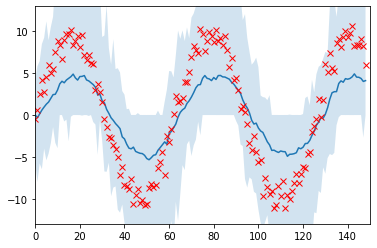

In [25]:
animate_model(tracker(), noisy_sin)